In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)
print('Device:', device)
print(torch.cuda.current_device())

Device: cuda
0


In [3]:
path = 'D:/data/새 폴더/_Noise data'
num_of_files = 1
num_of_datas = 11500

In [4]:
file_list = os.listdir(path)
file_list_py = [file for file in file_list[:num_of_files] if file.endswith('.csv')]
file_list_py

['Si_ 3 times0_1_10000_31426316.csv']

In [5]:
train = pd.DataFrame()
j = 0

for i in file_list_py:
    data = pd.read_csv(path+'/'+i,
                      skiprows=11,
                      nrows = num_of_datas,
                      header = None,
                      names =[j],
                      encoding = 'cp949'
                      )
    j = j + 1 
    train = pd.concat([train,data], axis = 1, sort=True)

In [6]:
train

,0
0,-0.016022
1,-0.013428
2,-0.010834
3,-0.008240
4,-0.003815
...,...
11495,0.026093
11496,0.026093
11497,0.028381
11498,0.025177


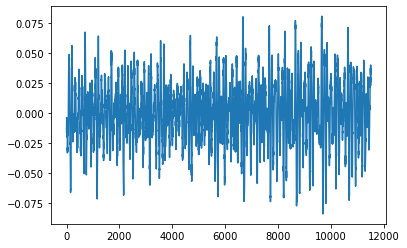

<Figure size 576x72 with 0 Axes>

In [7]:
plt.plot(train)
plt.figure(figsize=(8, 1))
plt.show()

## Test data load\


In [8]:
valid = pd.read_csv('D:/data/새 폴더/_Noise data/Si_ 3 times0_1_15_42000.csv',
                    encoding = 'cp949', skiprows = 11, names = [0])

In [9]:
valid = valid[:11500]
valid

,0
0,-0.014648
1,-0.014343
2,-0.014038
3,-0.013733
4,-0.014496
...,...
11495,-0.026703
11496,-0.035248
11497,-0.036316
11498,-0.032654


## data split

In [10]:
seq_len = 1000
pred_len = num_of_datas - seq_len

In [11]:
def truncate(x, train_len=seq_len, test_len=1):
    in_, out_ = [], []
    
    in_.append(x[:1000])
    out_.append(x[1000:])
    
    return np.array(in_), np.array(out_)
    


In [12]:
x_train, y_train = truncate(train)
x_val, y_val = truncate(valid)

In [13]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val)

In [14]:
print("x_train 사이즈 : {}".format(x_train.shape))
print("y_train 사이즈 : {}".format(y_train.shape))
print("x_val 사이즈 : {}".format(x_val.shape))
print("y_val 사이즈 : {}".format(y_val.shape))


x_train 사이즈 : torch.Size([1, 1000, 1])
y_train 사이즈 : torch.Size([1, 10500, 1])
x_val 사이즈 : torch.Size([1, 1000, 1])
y_val 사이즈 : torch.Size([1, 10500, 1])


## LSTM model

In [15]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from torch.autograd import Variable
import pytorch_model_summary

In [16]:
seq_len = x_train.shape[1]
input_size = x_train.shape[2]
hidden_size = 128
num_layers = 1
num_classes = 1 #y_train.shape[1]


In [17]:
x_train.shape

torch.Size([1, 1000, 1])

## LSTM cell

In [47]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
            
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True,
                            dropout = 0.3
                            )
        
        self.fc = nn.Linear(hidden_size, 1)
        self.timedis = TimeDistributed(self.fc)
        
        
    def forward(self, x):    
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
            
        output, (last_h, last_c) = self.lstm(x, (h_0,c_0))
        output = output[:,-1,:]   
        output = output.repeat(1, 10500, 1)
        
        return self.timedis(output)
            
            

In [57]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [48]:
model = Encoder(input_size, hidden_size, num_layers, num_classes).to(device)

In [51]:
test, last_h, last_c = model(x_train)

In [55]:
print(test.shape, last_h.shape)

torch.Size([1, 128]) torch.Size([1, 1, 128])


In [71]:
last_h

tensor([[[-0.0459,  0.0323,  0.0420,  0.0163,  0.0426, -0.0066, -0.0717,
           0.0413,  0.0446, -0.0095,  0.0482,  0.0112, -0.0059,  0.0574,
           0.0153, -0.0421,  0.0147,  0.0561, -0.0143, -0.0085,  0.0090,
           0.0181,  0.0053,  0.0244, -0.0279, -0.0785,  0.0233, -0.0139,
           0.0004, -0.0134,  0.0176,  0.0521,  0.0648, -0.0213,  0.0360,
          -0.0334,  0.0338,  0.0364,  0.0748, -0.0405,  0.0010,  0.0432,
           0.0037,  0.0416,  0.0513, -0.0647, -0.0310,  0.0051, -0.0153,
           0.0309, -0.0573, -0.0234, -0.0066, -0.0079, -0.0456,  0.0749,
          -0.0827,  0.0321,  0.0196,  0.0086,  0.0283,  0.0524,  0.0191,
          -0.0370, -0.0296, -0.0650,  0.0037,  0.0479, -0.0485, -0.0311,
          -0.0474,  0.0102,  0.0480, -0.0288, -0.0487, -0.0313, -0.0020,
          -0.0662,  0.0065, -0.0263, -0.0155,  0.0516, -0.0728,  0.0389,
          -0.0762, -0.0714, -0.0721, -0.0344,  0.0228,  0.0037, -0.0685,
           0.0016, -0.0449,  0.0537,  0.0040, -0.06

In [65]:
test2 = test.repeat(1, 10500, 1)

In [66]:
test2.shape

torch.Size([1, 10500, 128])

In [69]:
test2

tensor([[[-0.0459,  0.0323,  0.0420,  ...,  0.0074,  0.0179,  0.0065],
         [-0.0459,  0.0323,  0.0420,  ...,  0.0074,  0.0179,  0.0065],
         [-0.0459,  0.0323,  0.0420,  ...,  0.0074,  0.0179,  0.0065],
         ...,
         [-0.0459,  0.0323,  0.0420,  ...,  0.0074,  0.0179,  0.0065],
         [-0.0459,  0.0323,  0.0420,  ...,  0.0074,  0.0179,  0.0065],
         [-0.0459,  0.0323,  0.0420,  ...,  0.0074,  0.0179,  0.0065]]],
       device='cuda:0', grad_fn=<RepeatBackward>)

In [67]:
model2 = TimeDistributed(input).to(device)

In [20]:
model = Encoder(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)


Encoder(
  (lstm): LSTM(1, 128, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (timedis): TimeDistributed(
    (module): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [21]:
num_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss().to(device)

history = dict(train=[], val=[])
train_losses = []
val_losses = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       patience = 10, 
                                                       factor =0.5, 
                                                       min_lr=1e-7, 
                                                       eps = 1e-8
                                                      )

In [22]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [23]:
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    
    model = model.train()
    
    
    
    
    
    optimizer.zero_grad()
    pred = model(x_train)
    loss = criterion(torch.flatten(pred), torch.flatten(y_train))
    
    loss.backward()
    optimizer.step()
    
    
    train_losses.append(loss.item())
    
    
    model = model.eval()
    with torch.no_grad():
        valid = model(x_val)
        loss = criterion(torch.flatten(valid), torch.flatten(y_train))
        val_losses.append(loss.item())
    
        
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    
    history['train'].append(train_loss)
    history['val'].append(val_loss) 
    
    
    if epoch % 5 == 0 :
        print("----------------------------------------------------------------------")
        print("Epoch : {}  //  train loss : {} //  val loss : {}".format(epoch, train_loss, val_loss))
    

----------------------------------------------------------------------
Epoch : 0  //  train loss : 0.0009286098647862673 //  val loss : 0.07203372567892075
----------------------------------------------------------------------
Epoch : 5  //  train loss : 0.015026281160923341 //  val loss : 0.015559979132376611
----------------------------------------------------------------------
Epoch : 10  //  train loss : 0.009133071903224018 //  val loss : 0.009199464455543255
----------------------------------------------------------------------
Epoch : 15  //  train loss : 0.006607614966924302 //  val loss : 0.006626641443290282
----------------------------------------------------------------------
Epoch : 20  //  train loss : 0.005283274698913807 //  val loss : 0.005276464887650772
----------------------------------------------------------------------
Epoch : 25  //  train loss : 0.004428614665252658 //  val loss : 0.004428571213233786
------------------------------------------------------------

In [24]:
y_val = y_val.cpu().flatten()
valid = valid.cpu().flatten()

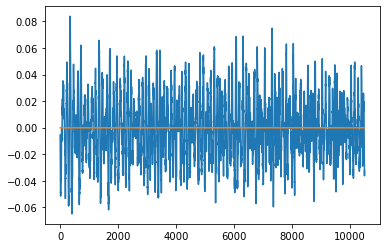

In [25]:
plt.plot(y_val)
plt.plot(valid)



In [92]:
valid

tensor([-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001])